In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [51]:
#Read the dataset
train = pd.read_csv("train.csv", parse_dates=["date"])
test = pd.read_csv( "test.csv", parse_dates=["date"])

oil = pd.read_csv("oil.csv", parse_dates=["date"]).rename(columns={"dcoilwtico": "oil"})
store = pd.read_csv( "stores.csv")
transaction = pd.read_csv( "transactions.csv", parse_dates=["date"])
holiday = pd.read_csv( "holidays_events.csv", parse_dates=["date"])

In [52]:
#Get some information about the data
num_family = train.family.nunique()
num_store = train.store_nbr.nunique()
num_ts = train.groupby(["store_nbr", "family"]).ngroups
train_start = train.date.min().date()
train_end = train.date.max().date()
num_train_date = train.date.nunique()
train_len = (train_end - train_start).days + 1
test_start = test.date.min().date()
test_end = test.date.max().date()
num_test_date = test.date.nunique()
test_len = (test_end - test_start).days + 1



In [53]:
#Reindex so it contains all dates
multi_idx = pd.MultiIndex.from_product(
    [pd.date_range(train_start, train_end), train.store_nbr.unique(), train.family.unique()],
    names=["date", "store_nbr", "family"],
)
train = train.set_index(["date", "store_nbr", "family"]).reindex(multi_idx).reset_index()

In [54]:
#Fill missing values
train[["sales", "onpromotion"]] = train[["sales", "onpromotion"]].fillna(0.)
train["id"] = train["id"].interpolate(method="linear")

In [55]:
#Calculate total sales and append to transaction
store_sales = train.groupby(["date", "store_nbr"]).sales.sum().reset_index()
store_sales.rename(columns = {'sales':'total_sales'}, inplace = True)
transaction = transaction.merge(
    store_sales,
    on=["date", "store_nbr"],
    how="outer",
).sort_values(["date", "store_nbr"], ignore_index=True)


In [56]:
#Simplify holiday data
holiday = holiday[holiday["transferred"] == False]
holiday = holiday[["date","locale"]]
holiday["is_holiday"] = 1

In [57]:
#Combine all datasets
data = train.merge(
    transaction, on=["date", "store_nbr"], how="left",
).merge(
    oil, on="date", how="left",
).merge(
    store, on="store_nbr", how="left",
).merge(
    holiday, on="date", how="left",
).sort_values(["date", "store_nbr", "family"], ignore_index=True)

In [58]:
#Find missing date
missing_dates = pd.date_range(train_start, train_end).difference(train.date.unique())
missing_dates = missing_dates.strftime("%Y-%m-%d").tolist()
missing_oil_dates = pd.date_range(train_start, test_end).difference(oil.date)
num_missing_oil_dates = len(missing_oil_dates)
num_wknd_missing = (missing_oil_dates.weekday >= 5).sum()
total_num_wknd = (pd.date_range(train_start, test_end).weekday >= 5).sum()

In [59]:
#Fill missing date in oil data set
oil_plot = oil.merge(
    pd.DataFrame({"date": pd.date_range(train_start, test_end)}),
    on="date",
    how="outer",
).sort_values("date", ignore_index=True)

oil_plot = oil_plot[oil_plot['date'].isin(data['date'].unique())]
oil_plot.oil = oil_plot.oil.interpolate(method="linear", limit_direction="both")

In [60]:
#Fill missing date in transaction dataset
store_sales = train.groupby(["date", "store_nbr"]).sales.sum().reset_index()
transaction_plot = transaction.merge(
    store_sales,
    on=["date", "store_nbr"],
    how="outer",
).sort_values(["date", "store_nbr"], ignore_index=True)

transaction_plot.loc[transaction_plot.sales.eq(0), "transactions"] = 0.
transaction_plot = transaction_plot.drop(columns=["sales"])

transaction_plot.transactions = transaction_plot.groupby("store_nbr", group_keys=False).transactions.apply(
    lambda x: x.interpolate(method="linear", limit_direction="both")
)

In [61]:
#get average sales, promo, and transactions
average_sales_per_date = data.groupby('date')['sales'].mean()
average_promo_per_date = data.groupby('date')['onpromotion'].mean()
average_trans_per_date = transaction_plot.groupby('date')['transactions'].mean()
average_sales = store_sales.groupby('date').mean()['sales'].to_frame()

In [14]:
#create holiday dataframe for plotting
data[["is_holiday"]] = data[["is_holiday"]].fillna(0.)
holiday_plot = data.groupby('date')['is_holiday'].mean()
holiday_plot = holiday_plot.replace({0:"No",1:"Yes"})
holiday_plot = pd.DataFrame({'Category': holiday_plot, 'Sales': average_sales_per_date})

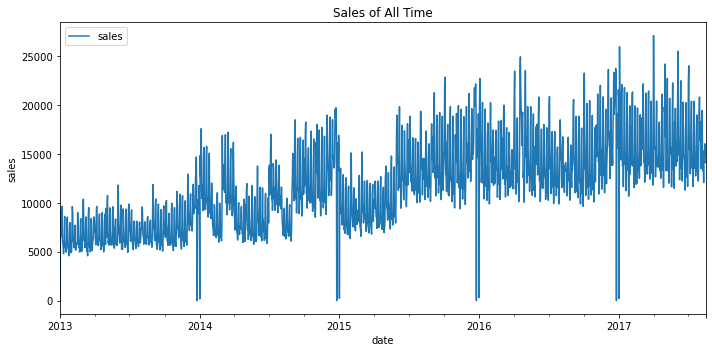

In [120]:
fig, ax = plt.subplots(figsize=(10,5))
average_sales.plot(ax=ax)
plt.ylabel("sales")
plt.title("Sales of All Time")
plt.tight_layout()
plt.savefig('Sales of All Time',dpi = 600)

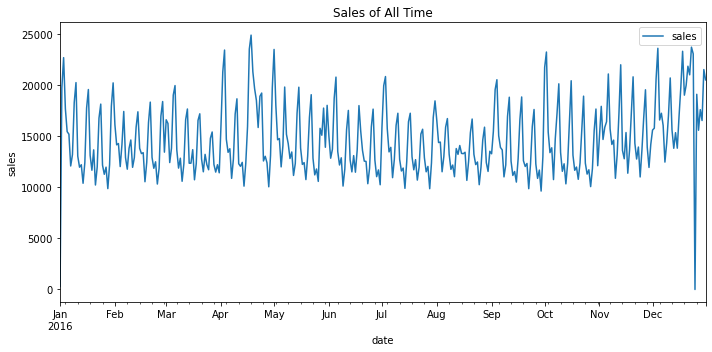

In [121]:
average_sales.loc[(average_sales.index >= '2016-01-01') & (average_sales.index < '2017-01-01')].plot(figsize=(10,5), title='Sales in One Year')
plt.ylabel("sales")
plt.title("Sales of All Time")
plt.tight_layout()
plt.savefig('Sales in One Year',dpi = 600)

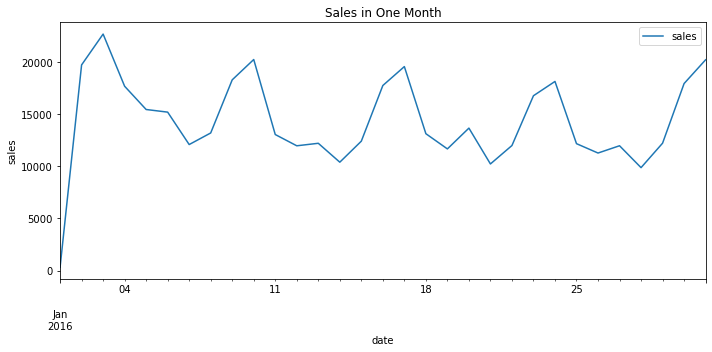

In [122]:
average_sales.loc[(average_sales.index >= '2016-01-01') & (average_sales.index < '2016-02-01')].plot(figsize=(10,5),title='Sales in One Month')
plt.ylabel("sales")
plt.tight_layout()
plt.savefig('Sales in One Month',dpi = 600)

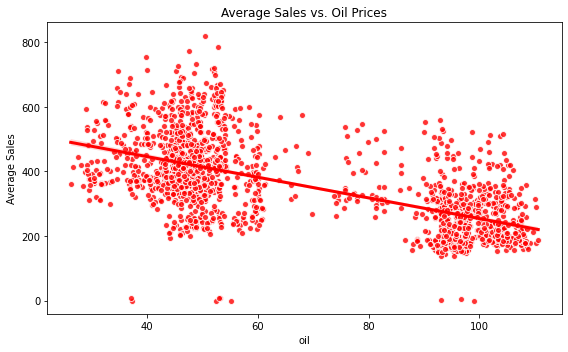

In [98]:
plt.figure(figsize=(8, 5))


plot_kwargs = {
    "scatter_kws": {"edgecolor": "white"},
    "line_kws": {"lw": 3},
}

sns.regplot(
    x=oil_plot['oil'], y=average_sales_per_date,    
    color='red',
    **plot_kwargs,
)

plt.ylabel("Average Sales")
plt.title("Average Sales vs. Oil Prices")


plt.savefig('Average Sales vs Oil Prices',dpi = 600)
plt.tight_layout()
plt.show()

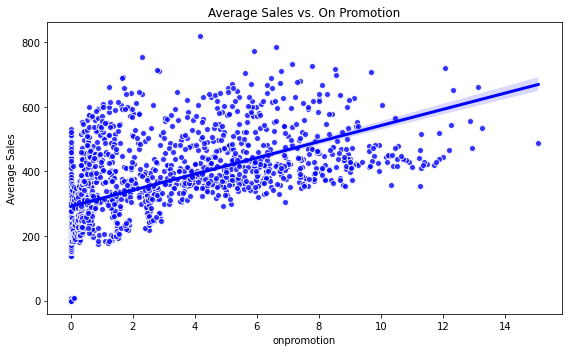

In [101]:
fig = plt.figure(figsize=(8, 5))

sns.regplot(
    x=average_promo_per_date, y=average_sales_per_date,    
    color='blue',
    **plot_kwargs,
)

plt.ylabel("Average Sales")
plt.title("Average Sales vs. On Promotion")


plt.savefig('Average Sales vs On Promotion',dpi = 600)
plt.tight_layout()
plt.show()

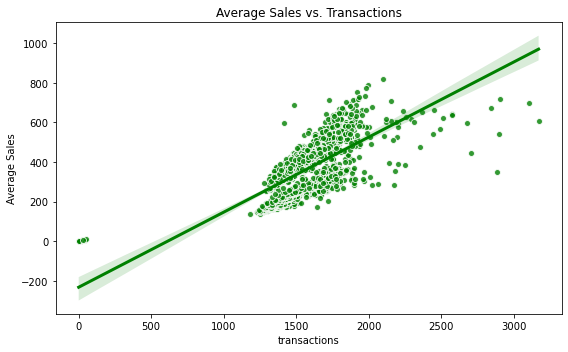

In [102]:
fig = plt.figure(figsize=(8, 5))

sns.regplot(
    x=average_trans_per_date, y=average_sales_per_date,    
    color='green',
    **plot_kwargs,
)

plt.ylabel("Average Sales")
plt.title("Average Sales vs. Transactions")

plt.savefig('Average Sales vs Transactions',dpi = 600)

plt.tight_layout()
plt.show()

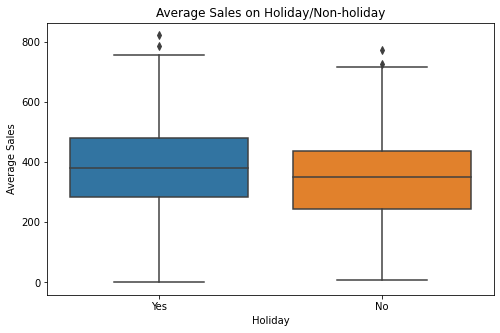

In [104]:
fig = plt.figure(figsize=(8, 5))
sns.boxplot(x='Category', y='Sales', data=holiday_plot)
plt.xlabel('Holiday')
plt.ylabel("Average Sales")
plt.title('Average Sales on Holiday/Non-holiday')
plt.savefig('Average Sales on Holiday',dpi = 600)
plt.show()

In [20]:
#Use only one store for training
data =data[data.store_nbr == 1]

In [21]:
#Fill missing data and convert date
from datetime import datetime

data[["is_holiday"]] = data[["is_holiday"]].fillna(0.)
data[["locale"]] = data[["locale"]].fillna("None")
data[["is_holiday"]] = data[["is_holiday"]].fillna(0.)
data[["locale"]] = data[["locale"]].fillna("None")
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['day'] = data['date'].dt.day
data['weekday'] = data['date'].dt.weekday
data = data.drop(columns=['date', 'id'])

In [23]:
#Define types of features
cat_ftrs = ['store_nbr','family','city','state','type','cluster','month','day','weekday']
ordinal_ftrs = ['locale','is_holiday']
ordinal_cats = [['None','Local','Regional','National'],[0.0,1.0]]
num_ftrs = ['onpromotion','transactions','total_sales','oil','year']

In [24]:
#Construct the preprocessor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse_output=False,handle_unknown='ignore'))])

ordinal_transformer = Pipeline(steps=[
    ('ordinal', OrdinalEncoder(categories = ordinal_cats))])

numeric_transformer = Pipeline(steps=[
    ('iterative imputer', IterativeImputer(estimator = LinearRegression())),
    ('scaler', StandardScaler())])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, cat_ftrs),
        ('ord', ordinal_transformer, ordinal_ftrs),
        ('num', numeric_transformer, num_ftrs)])

In [25]:
#Define the pipeline
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error

def MLpipe_TimeSeriesSplit_RMSE(X, y, preprocessor, ML_algo, param_grid):

    test_scores = []
    best_models = []
    for i in range(n_iterations):
        X_train = X[X['year'] < 2017]
        X_test = X[X['year'] == 2017]
        y_train = y.iloc[:len(X_train)]
        y_test = y.iloc[len(X_train):]

        X_train = preprocessor.fit_transform(X_train)
        X_test = preprocessor.transform(X_test)

        tscv = TimeSeriesSplit(n_splits=4)
        grid = GridSearchCV(estimator=ML_algo, param_grid=param_grid, 
                            cv=tscv, return_train_score=True)
        grid.fit(X_train, y_train)

        best_model = grid.best_estimator_
        best_models.append(best_model)

        y_pred = best_model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        test_scores.append(rmse)

    return test_scores, best_models

In [26]:
#Define parameter grid
from sklearn.linear_model import ElasticNet,Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
import xgboost

def lasso_param_grid():
    return {'alpha': np.logspace(-2,2,20)}
def elasticnet_param_grid():
    return {'alpha': np.logspace(-2,2,6), 'l1_ratio': [0.1, 0.3, 0.7]}
def rf_param_grid():
    return {'max_depth': [1, 3, 10, 30, 100], 'n_estimators': [1, 3, 10, 30]}
def knn_param_grid():
    return {'n_neighbors': list(range(1, 11)), 'weights': ['uniform', 'distance']}
def xgboost_param_grid():
    return{'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [1, 5, 10, 30]}


models = [('Lasso', ElasticNet(), lasso_param_grid()),
          ('ElasticNet', ElasticNet(), elasticnet_param_grid()), 
          ('RandomForest', RandomForestRegressor(), rf_param_grid()), 
          ('KNN', KNeighborsRegressor(), knn_param_grid()),
          ('XGBoost', xgboost.XGBRegressor(),xgboost_param_grid())]


In [27]:
#Train and save models
X = data.drop(columns = ['sales'])
y = data['sales']
results = {}
n_iterations = 5
for name, model, param_grid in models:
    print(f'Training {name}')
    test_scores, best_models = MLpipe_TimeSeriesSplit_RMSE(X, y, preprocessor, model, param_grid)
    results[name] = {'mean_score': np.mean(test_scores), 'std_score': np.std(test_scores), 'models':best_models}
    print(f'The model {name} has mean score of {np.mean(test_scores)} and sd of {np.std(test_scores)}')

Training Lasso
The model Lasso has mean score of 300.6329795118315 and sd of 0.0
Training ElasticNet
The model ElasticNet has mean score of 289.96434730236194 and sd of 0.0
Training RandomForest
The model RandomForest has mean score of 92.11694469932094 and sd of 17.569682775905978
Training KNN
The model KNN has mean score of 169.1996162940438 and sd of 0.0
Training XGBoost
The model XGBoost has mean score of 78.6377883492488 and sd of 0.0


In [140]:
#Save model dictionary
import csv
w = csv.writer(open("model.csv", "w"))

for key, val in results.items():

    w.writerow([key, val])


In [34]:
#Get RMSE and R sqaure scores
from sklearn.metrics import r2_score
X_train = X[X['year'] < 2017]
X_test = X[X['year'] == 2017]
y_train = y.iloc[:len(X_train)]
y_test = y.iloc[len(X_train):]
X_test = preprocessor.transform(X_test)
R2_scores = []
predictions = []
for i in range(len(models)):
    R2_score = []
    prediction = []
    for j in range(n_iterations):
        model = models[i][j]
        y_pred = model.predict(X_test)
        R2_score.append(r2_score(y_test, y_pred))
        prediction.append(y_pred)
    R2_scores.append(R2_score)
    predictions.append(prediction)

mean_scores = [results[model]['mean_score'] for model in results]
std_scores = [results[model]['std_score'] for model in results]
models = [results[model]['models'] for model in results]

R2_std = [np.std(x) for x in R2_scores]
R2 = [np.mean(x) for x in R2_scores]

baseline_pred_r2 = y_train.mean()
baseline_R2 = r2_score(y_test,[baseline_pred_r2]*len(y_test))
baseline_pred_rmse = y_train.median()
baseline_rmse = np.sqrt(mean_squared_error(y_test,[baseline_pred_r2]*len(y_test)))

In [132]:
#Combine predictions for plotting
combined_data = [x[0] for x in predictions]
combined_data.insert(0,y_test.to_numpy())

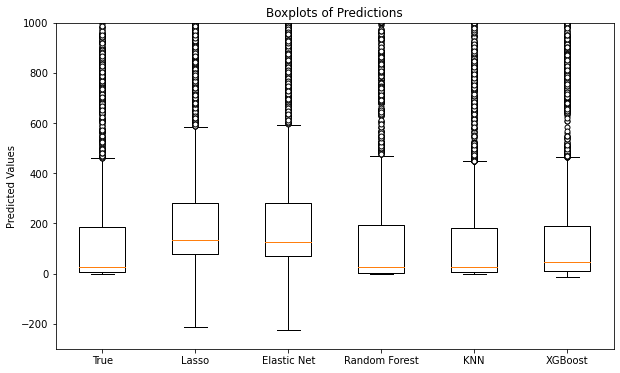

In [133]:
#Plot boxplot of distribution of predictions
flierprops = dict(marker='o', markerfacecolor='white', markersize=5, 
                  linestyle='none')
plt.figure(figsize=(10,6))
plt.boxplot(combined_data, flierprops=flierprops)
plt.title('Boxplots of Predictions')
plt.ylabel('Predicted Values')
plt.ylim(-300, 1000)
plt.xticks([1, 2, 3,4,5,6], ['True','Lasso','Elastic Net', 'Random Forest', 'KNN', 'XGBoost'])
plt.savefig('dsdsa')

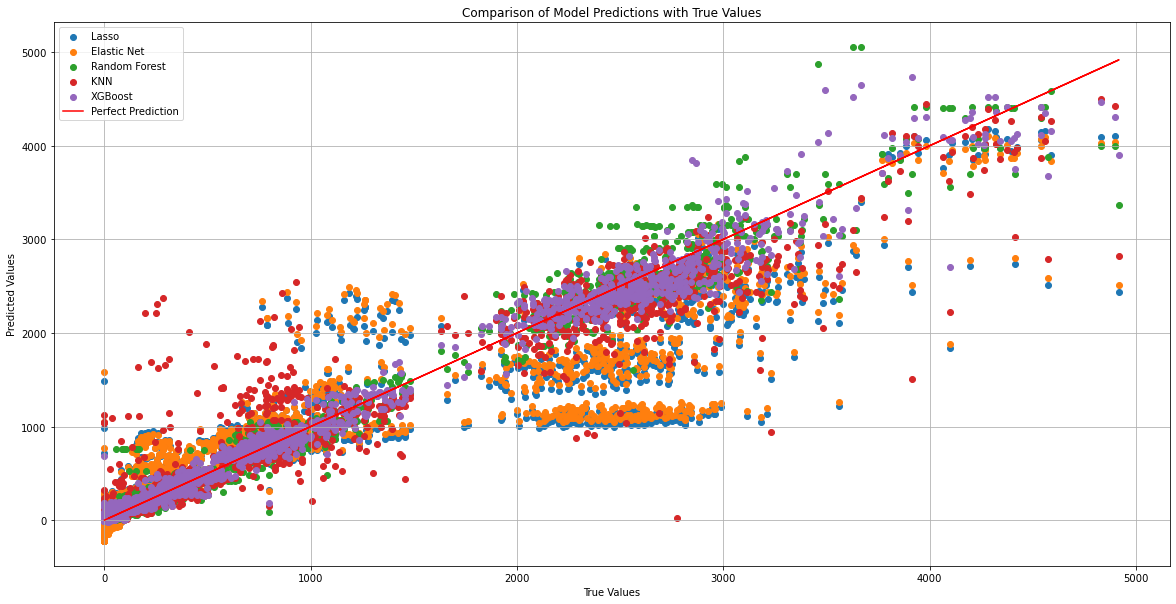

In [42]:
model_name = ['True','Lasso','Elastic Net', 'Random Forest', 'KNN', 'XGBoost']

plt.figure(figsize=(20,10))
for i in range(1,6):
    plt.scatter(combined_data[0], combined_data[i],label=model_name[i])
plt.plot(combined_data[0], combined_data[0], color='red', label='Perfect Prediction')

plt.title('Comparison of Model Predictions with True Values')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid(True)
plt.savefig('fdfsf')
plt.show()


In [31]:
#Get feature names and map for plotting
feature_names = preprocessor.get_feature_names_out()
feature_map = {f'f{i}': name for i, name in enumerate(feature_names)}

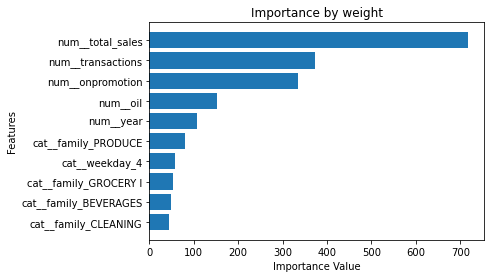

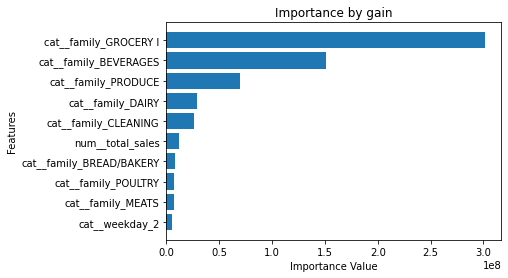

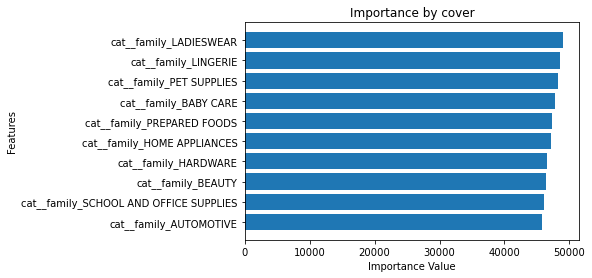

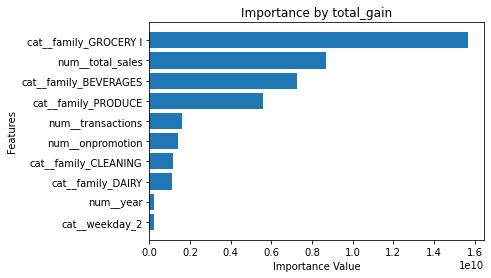

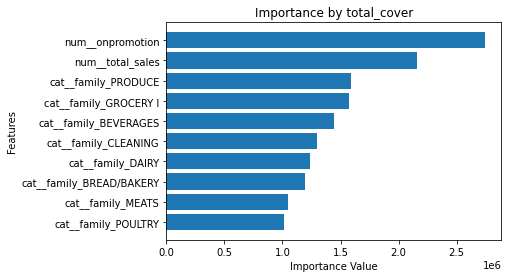

In [54]:
importance_types = ['weight', 'gain', 'cover', 'total_gain', 'total_cover']
for type in importance_types:
    model = results['XGBoost']['models'][0]
    importance = model.get_booster().get_score(importance_type=type)
    importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)[:10]

    features = [feature_map.get(item[0], item[0]) for item in importance][::-1]
    values = [item[1] for item in importance][::-1]
    plt.barh(np.arange(10),values)
    plt.yticks(np.arange(10),features)
    plt.xlabel('Importance Value')
    plt.ylabel('Features')
    plt.title(f'Importance by {type}')
    plt.savefig(type,dpi=600, bbox_inches = 'tight')
    plt.show()


In [57]:
#Disable warnings
import warnings
warnings.filterwarnings('ignore')

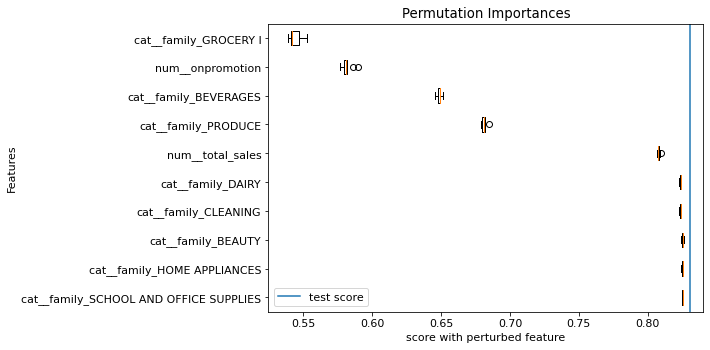

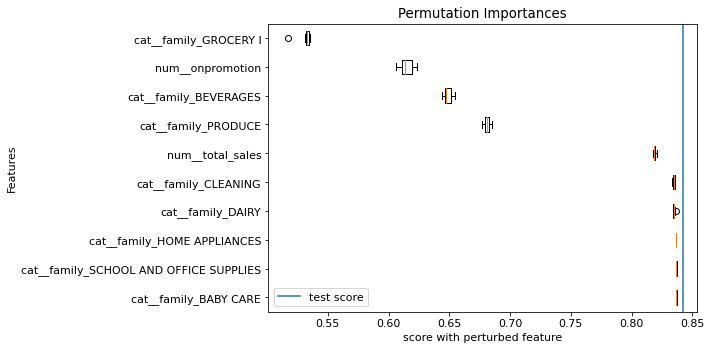

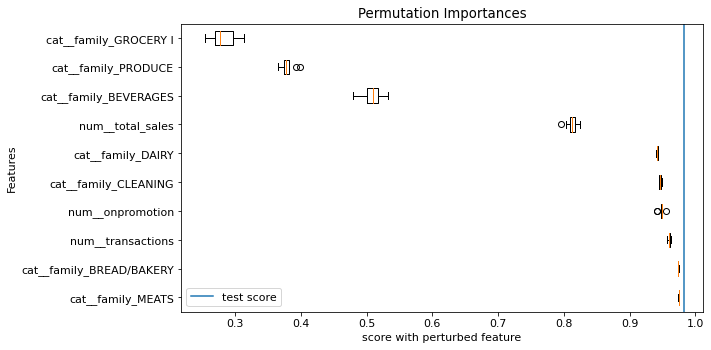

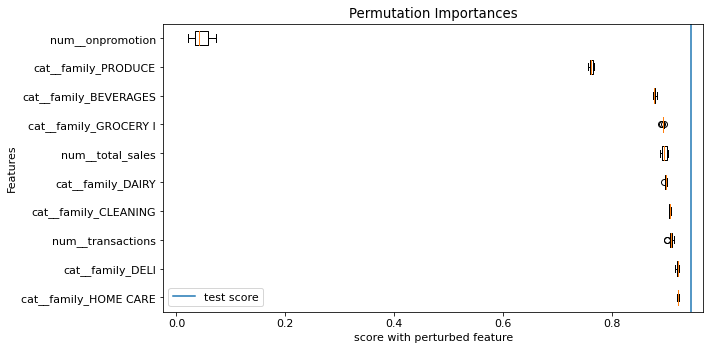

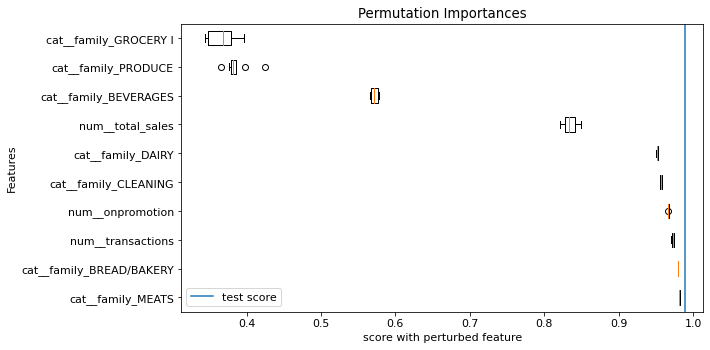

In [59]:
#Plot permutation importance
df_test = pd.DataFrame(data=X_test,columns=feature_names)
nr_runs = 10
for model_name in results:
    scores = np.zeros([len(feature_names),nr_runs])
    model = results[model_name]['models'][0]
    test_score = model.score(df_test,y_test)
    for i in range(len(feature_names)):
        acc_scores = []
        for j in range(nr_runs):
            X_test_shuffled = df_test.copy()
            X_test_shuffled[feature_names[i]] = np.random.permutation(df_test[feature_names[i]].values)
            acc_scores.append(model.score(X_test_shuffled,y_test))
        scores[i] = acc_scores
    sorted_indcs = np.argsort(np.mean(scores,axis=1))[::-1][-10:]
    plt.rcParams.update({'font.size': 11})
    plt.figure(figsize=(10,5))
    plt.boxplot(scores[sorted_indcs].T,labels=feature_names[sorted_indcs],vert=False)
    plt.axvline(test_score,label='test score')
    plt.title("Permutation Importances")
    plt.xlabel('score with perturbed feature')
    plt.ylabel('Features')
    plt.legend()
    plt.tight_layout()
    plt.savefig(str(model_name),dpi=600, bbox_inches = 'tight')
    plt.show()

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


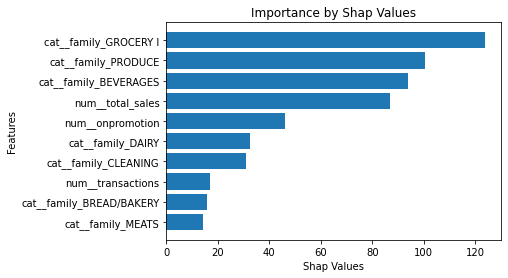

In [135]:
#Plot global shap value
import shap

shap.initjs()

model = results['XGBoost']['models'][0]
explainer = shap.Explainer(model)
shap_values = explainer.shap_values(df_test)
mean_shap_values = np.abs(shap_values).mean(axis=0)

sorted_indcs = np.argsort(mean_shap_values)[-10:]

plt.barh(np.arange(10),mean_shap_values[sorted_indcs])
plt.yticks(np.arange(10),feature_names[sorted_indcs])
plt.xlabel('Shap Values')
plt.ylabel('Features')
plt.title(f'Importance by Shap Values')
plt.savefig('shap',dpi=600, bbox_inches = 'tight')
plt.show()

<Figure size 1440x864 with 0 Axes>

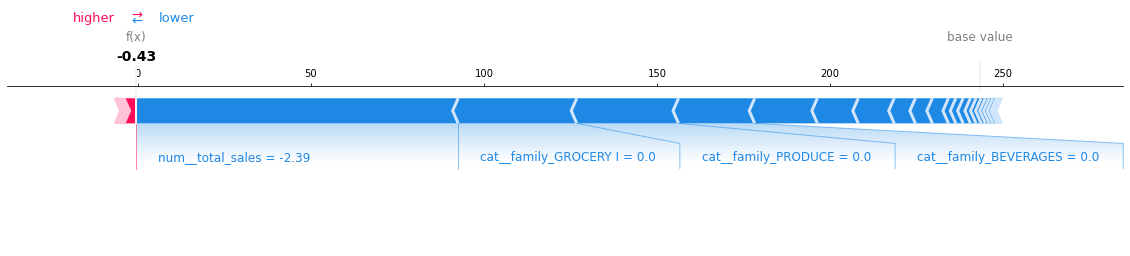

<Figure size 432x288 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

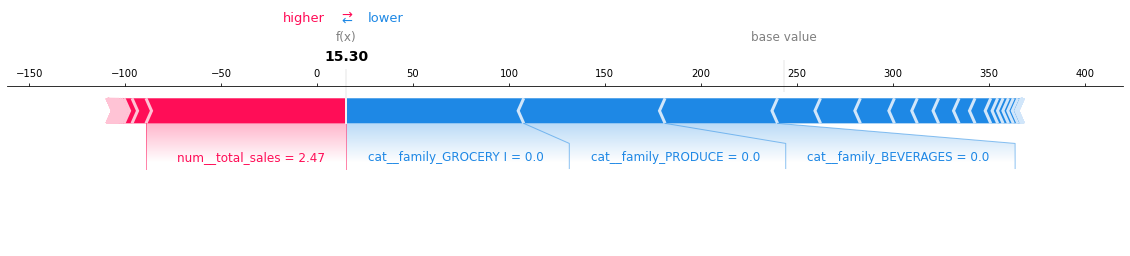

<Figure size 432x288 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

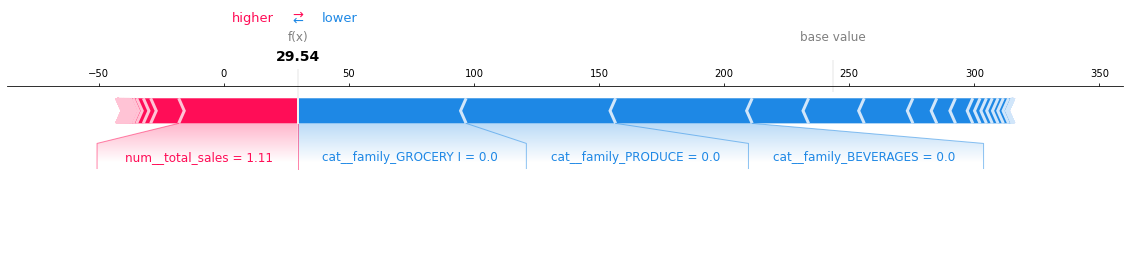

<Figure size 432x288 with 0 Axes>

In [136]:
#plot local shap value
index_list = [0,100,200]
df_test_rounded = df_test.round(2)
for index in index_list:   
    plt.figure(figsize = (20,12))
    shap.force_plot(explainer.expected_value, shap_values[index, :], df_test_rounded.iloc[index, :], feature_names=feature_names, matplotlib=True)
    plt.tight_layout()
    plt.savefig('shap_plot_' + str(index) + '.png', dpi=600)
    plt.show()